<a href="https://colab.research.google.com/github/Yodai1996/CV/blob/master/Invertible_Residual_Network_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import torch
from torch import nn
from torch import optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable
import torch.distributions as distributions

In [88]:
!pip install torch torchvision

import torch
torch.cuda.is_available()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input and output

Fashion mnistの前にとりあえずmnistで実験してみる。


In [0]:
FILE_NAME  = "./sample_data/mnist_train_small.csv"
FILE_NAME2 = "./sample_data/mnist_test.csv"

num_epoch = 2

In [90]:
labels = []    #今回これは特に使わないが。
data   = []

#[0,255]の1bit整数型のままで。floatにキャストする必要はあるかも？
with open(FILE_NAME) as f:
  reader = csv.reader(f)
  for row in reader:
    labels.append(float(row[0]))
    data.append([float(elem) for elem in row[1:]])

#data整形    
data = np.array(data)
size = data.shape[0]
data = data.reshape([size, 28, 28])  #reshapeしてモデル立てる必要ありそう。
data.shape  

(20000, 28, 28)

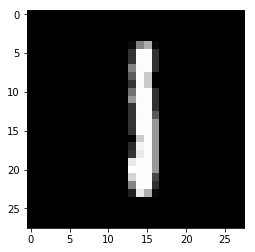

In [91]:
fig, ax = plt.subplots()
ax.imshow(data[-4], cmap="gray")
plt.show()

define a model of Invertible Residual Network

必要があれば、dataloaderやmini-batch処理を実装する。👈必要ありそう（一気にはメモリにのらない）

In [0]:
#define a model of i-Resnet
#quite simple version, for just trying
#とりあえずリプシッツ定数の話はガン無視。
#actnorm is not used. I used relu instead of elu

class I_RESNET(nn.Module):
  
  def __init__(self):
    super(I_RESNET, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=1, stride=1, padding=0) #Noneはchainer仕様故使えない。
    self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)    
    self.conv3 = nn.Conv2d(32, 32, kernel_size=1, stride=1, padding=0)    

    #さすがに3層だけではしょぼいかと思い、追加してみた。
    #全体的なResidual Networkの構造はやや変えてある。
    self.conv4 = nn.Conv2d(32, 32, kernel_size=1, stride=1, padding=0)
    self.conv5 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)    
    self.conv6 = nn.Conv2d(32, 1, kernel_size=1, stride=1, padding=0)     #channelを入力時のと同じにする。   
    
  def forward(self, x_in):
    x = F.relu(self.conv1(x_in))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = F.relu(self.conv5(x))
    x = self.conv6(x)
    z = x + x_in #residual
    
    #とりあえずlogdetの計算部分はガン無視。（126行目に対応）
    #いや、それがないとlossの計算ができないので必要。(actnormは無視している。)👈嘘。
    #リップシツがないので本当は絶対値外せない。それがどう影響するか。
    return z
  
  def inverse(self, z, maxIter=1):
    x_in = z
    for iter_index in range(maxIter):
      #bottleneck_block部分。また同じの書くのダサいが。
      #方程式の解を求めるのに、反復法を回す。いま、invertibleとは限らないのがどう影響するか。
      x = F.relu(self.conv1(x_in))
      x = F.relu(self.conv2(x))
      x = F.relu(self.conv3(x))
      x = F.relu(self.conv4(x))
      x = F.relu(self.conv5(x))
      summand = self.conv6(x) 
      
      x_in = z - summand
     
    return x_in

ソースコード、trainはどこでやってる

（すでに学習済みのモデルを使ってる？？）

---



In [0]:
dim = 28*28 #これで合ってるのか？わからん。

prior_mu     = nn.Parameter(torch.zeros((dim,)).float(), requires_grad=True) #Trueにしたい。
prior_logstd = nn.Parameter(torch.zeros((dim,)).float(), requires_grad=True)


#prior_mu     = torch.zeros((dim,)).float()
#prior_logstd = torch.zeros((dim,)).float()

def logpz(z):
  prior = distributions.Normal(prior_mu, torch.exp(prior_logstd))
  return prior.log_prob(z.reshape(z.shape[0], -1)).sum(dim=1)

#これは何？
def bits_per_dim(logpx, inputs):
  return -logpx / float(np.log(2.) * np.prod(inputs.shape[1:])) + 8.

In [0]:
#inputs
x = data.reshape([size, 1, 28, 28])  #1 means only one channel. requires_grad=True
#x = torch.tensor(x, dtype=torch.float, device=device)

#data_loader
trainloader = torch.utils.data.DataLoader(x, batch_size=128, shuffle=True, num_workers=1)

In [95]:
#training of the model
model = I_RESNET().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
model.train()


losses = []
for i in range(num_epoch):
  temp_loss = 0
  for batch_id, inputs in enumerate(trainloader):
    inputs = torch.tensor(inputs, dtype=torch.float, device=device)
    z = model(inputs)
    
    z = z.cpu().detach() #.numpy()
    logpx = logpz(z) #logdetはとりま無視。
    loss  = bits_per_dim(logpx, inputs).mean()
    
    
    temp_loss += loss
    loss.backward()
    optimizer.step()
    
  losses.append(loss.cpu().detach().numpy())
  print("EPOCH: {} loss: {}".format(i, loss)) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


EPOCH: 0 loss: 4689.0126953125
EPOCH: 1 loss: 4707.591796875


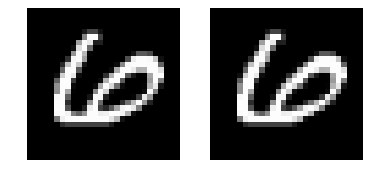

23.521472044289112


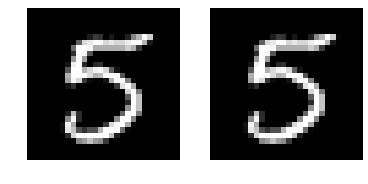

19.43570353090763


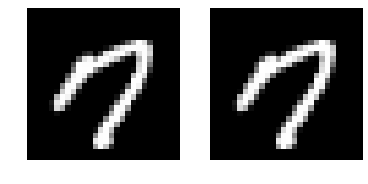

20.41596795618534


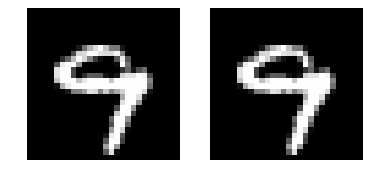

20.484547425061464


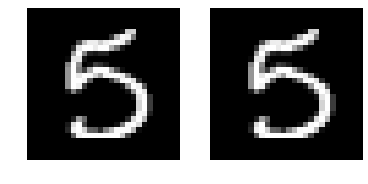

20.074021734297276


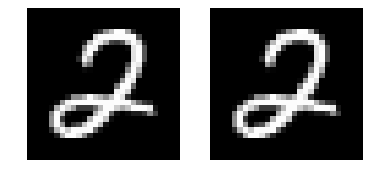

22.2943418584764


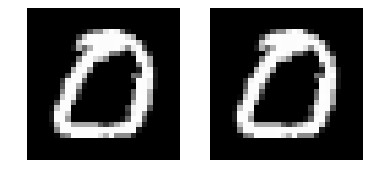

27.908267721533775


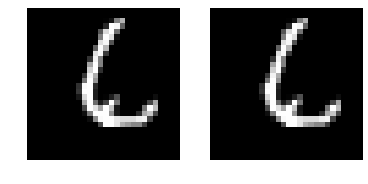

13.201960545033216


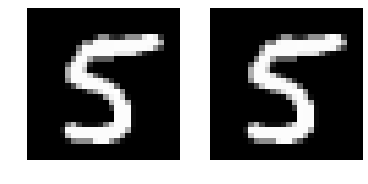

24.82734364271164


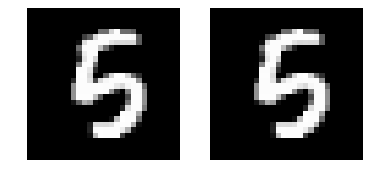

22.756109096109867


In [96]:
diff = lambda x,y : np.sum(abs((x-y)))

#samplingしたい。とりま10個。
n = 10

x_in = x[:n]
inputs = torch.tensor(x_in, dtype=torch.float, device=device)
z = model(inputs)
x_reconstruct = model.inverse(z)
x_reconstruct = x_reconstruct.cpu().detach().numpy()

x_in  = x_in.reshape([n,28,28])
x_out = x_reconstruct.reshape([n,28,28])
  
for i in range(n):  
  fig, axes = plt.subplots(1, 2)
  axes[0].set_axis_off()
  axes[0].imshow(x_in[i], cmap="gray")

  axes[1].set_axis_off()
  axes[1].imshow(x_out[i], cmap="gray")

  plt.show()
  
  print(diff(x_in[i], x_out[i])) 
  

In [97]:
temp_loss = 0
for batch_id, inputs in enumerate(trainloader):
  inputs = torch.tensor(inputs, dtype=torch.float, device=device)
  z = model(inputs)

  z = z.cpu().detach() #.numpy()
  logpx = logpz(z) #logdetはとりま無視。
  loss  = bits_per_dim(logpx, inputs).mean()


  temp_loss += loss
  loss.backward()
  optimizer.step()

losses.append(loss.cpu().detach().numpy())
print("EPOCH: {} loss: {}".format(i, loss)) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


EPOCH: 9 loss: 5323.9111328125


In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
testloader  = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=4)

for batch_id, inputs


In [0]:
#reconstruct_loss
diff = lambda x,y : (x-y).abs().sum()

#inputs
x = data.reshape([size, 1, 28, 28])  #1 means only one channel. requires_grad=True
x = torch.tensor(x, dtype=torch.float, device=device) # instead of new_
model = I_RESNET().to(device)
z = model(x)
for i in range(10):
  x_reconstruct = model.inverse(z, maxIter=i)
  print(i, diff(x, x_reconstruct))   #iter回すほど結果が良くなるはず。
  




In [0]:
#define a model of VAE
class VAE(nn.Module):
  
  def __init__(self, dim=500 ,latent_dim=20):
    super(VAE, self).__init__()    
    self.en_dense1 = nn.Linear(28*28, dim)
    self.en_dense2 = nn.Linear(dim, dim)
    self.mean   = nn.Linear(dim, latent_dim)
    self.var    = nn.Linear(dim, latent_dim)    
    self.de_dense1 = nn.Linear(latent_dim, dim)
    self.de_dense2 = nn.Linear(dim, dim)
    self.de_dense3 = nn.Linear(dim, 28*28)
    
  def _encoder(self, x):
    x    = F.relu(self.en_dense1(x))
    x    = F.relu(self.en_dense2(x))
    mean = self.mean(x)
    var  = F.softplus(self.var(x)) #variance should be always non-negative
    return mean, var  
  
  def _hidden_sampling(self, mean, var): #無相関と仮定
    eps = torch.randn(mean.shape).to(device)
    return mean + torch.sqrt(var)*eps
  
  def _decoder(self, z):
    x = F.relu(self.de_dense1(z))
    x = F.relu(self.de_dense2(x))    
    x = F.relu(self.de_dense3(x))    
    x = F.sigmoid(x)  #limit the output in [0,1]
    return x    
  
  
  def forward(self, x): 
    mean, var = self._encoder(x)
    z = self._hidden_sampling(mean, var)
    y = self._decoder(z)
    return y, z
  
  
  def loss(self, x): 
    mean, var = self._encoder(x)
    kl = -0.5 *  torch.mean(torch.sum(1+torch.log(var) - mean**2 - var)) #無相関ver
    z  = self._hidden_sampling(mean, var)
    y  = self._decoder(z)
    reconstruct = torch.mean(torch.sum(x * torch.log(y) + (1-x) * torch.log(1-y)))     #y is [0,1] so non-negative, so log make sense. 
    return -(reconstruct - kl) 